In [1]:
import pandas as pd
# NeuralProphet 클래스 불러오기
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
from sklearn.metrics import mean_squared_error, mean_absolute_error

C:\Users\tj-bu\AppData\Roaming\Python\Python310\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
df = pd.read_csv("인천교통공사_역별일별 이용인원현황_20230630.csv", encoding='cp949')
df

호선        통행일자  역명  구분  이용인원
0       1  2022-07-01  계양  승차  3425
1       1  2022-07-01  계양  하차  3307
2       1  2022-07-02  계양  승차  2826
3       1  2022-07-02  계양  하차  2862
4       1  2022-07-03  계양  승차  2074
...    ..         ...  ..  ..   ...
49635   7  2023-06-28  석남  하차  6791
49636   7  2023-06-29  석남  승차  7061
49637   7  2023-06-29  석남  하차  6193
49638   7  2023-06-30  석남  승차  8160
49639   7  2023-06-30  석남  하차  7216

[49640 rows x 5 columns]

In [3]:
df=df[df['구분']=='하차']
df.drop(['호선','구분'], axis=1,inplace=True)
df

WARNING - (py.warnings._showwarnmsg) - C:\Users\tj-bu\AppData\Local\Temp\ipykernel_10036\990016310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['호선','구분'], axis=1,inplace=True)



통행일자  역명  이용인원
1      2022-07-01  계양  3307
3      2022-07-02  계양  2862
5      2022-07-03  계양  2325
7      2022-07-04  계양  3309
9      2022-07-05  계양  3368
...           ...  ..   ...
49631  2023-06-26  석남  6230
49633  2023-06-27  석남  6717
49635  2023-06-28  석남  6791
49637  2023-06-29  석남  6193
49639  2023-06-30  석남  7216

[24820 rows x 3 columns]

In [4]:
df = df[['통행일자', '이용인원', '역명']]
df

통행일자  이용인원  역명
1      2022-07-01  3307  계양
3      2022-07-02  2862  계양
5      2022-07-03  2325  계양
7      2022-07-04  3309  계양
9      2022-07-05  3368  계양
...           ...   ...  ..
49631  2023-06-26  6230  석남
49633  2023-06-27  6717  석남
49635  2023-06-28  6791  석남
49637  2023-06-29  6193  석남
49639  2023-06-30  7216  석남

[24820 rows x 3 columns]

In [5]:
df.columns = ['ds', 'y', 'location']
df['ds'] = pd.to_datetime(df['ds'])
df

ds     y location
1     2022-07-01  3307       계양
3     2022-07-02  2862       계양
5     2022-07-03  2325       계양
7     2022-07-04  3309       계양
9     2022-07-05  3368       계양
...          ...   ...      ...
49631 2023-06-26  6230       석남
49633 2023-06-27  6717       석남
49635 2023-06-28  6791       석남
49637 2023-06-29  6193       석남
49639 2023-06-30  7216       석남

[24820 rows x 3 columns]

In [6]:
df1 = df[df['location']=='인천시청']
df1 = df1[['ds','y']]
df1

ds     y
10221 2022-07-01  5768
10223 2022-07-02  3521
10225 2022-07-03  2583
10227 2022-07-04  5281
10229 2022-07-05  5711
...          ...   ...
37221 2023-06-26  3279
37223 2023-06-27  3704
37225 2023-06-28  3784
37227 2023-06-29  3256
37229 2023-06-30  3608

[730 rows x 2 columns]

In [7]:
# 원본 데이터프레임에서 랜덤하게 10%의 행을 선택하여 새로운 데이터프레임 생성
df1_sampled = df1.sample(frac=0.1, random_state=42)

# 선택한 행을 원본 데이터프레임에서 제거
df1_drop = df1.drop(df1_sampled.index)
df1_sampled = df1_sampled.sort_values(by='ds')

df1_sampled

ds     y
36521 2022-07-11  3363
10241 2022-07-11  5194
36535 2022-07-18  3322
10287 2022-08-03  4516
10299 2022-08-09  4447
...          ...   ...
37203 2023-06-17  2685
10931 2023-06-21  5754
37211 2023-06-21  3662
10933 2023-06-22  5779
10947 2023-06-29  5143

[73 rows x 2 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24820 entries, 1 to 49639
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        24820 non-null  datetime64[ns]
 1   y         24820 non-null  int64         
 2   location  24820 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 775.6+ KB


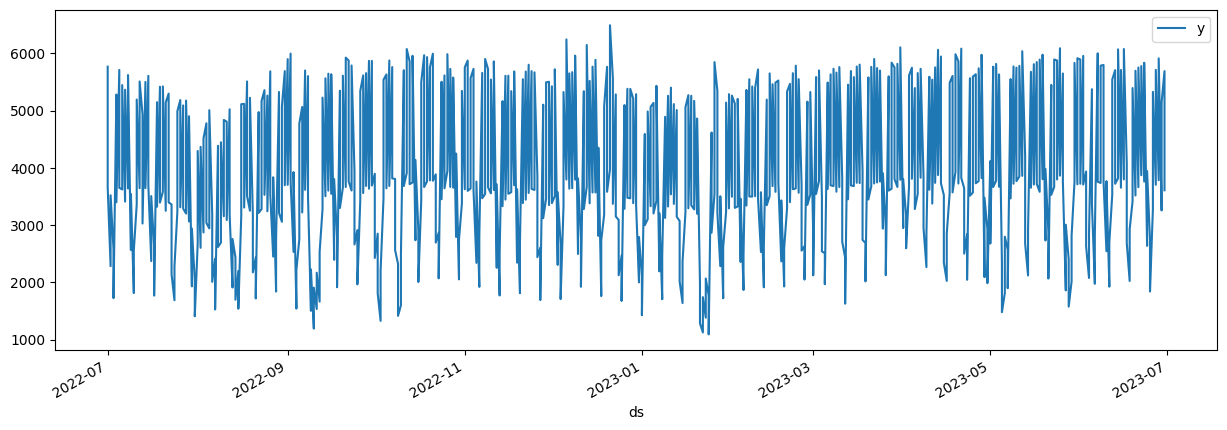

In [9]:
plt = df1.plot(x="ds", y="y", figsize=(15, 5))

In [10]:
# 오류가 아닌 경우 로깅 메시지 비활성화
set_log_level("ERROR")
set_random_seed(0)

# 기본 매개변수로 NeuralProphet 모델 생성
m = NeuralProphet(
#     trend_reg=1, # 트렌드의 기울기(높을수록 기울기가 낮아짐)
    
#     n_changepoints=0,
    # Enable all seasonality components
    yearly_seasonality=True,
    weekly_seasonality=True,
#     daily_seasonality=True,
#     n_lags=10,
#     n_forecasts=30
)

# df1_train, df1_val = m.split_df(df1, valid_p=0.1)
print("Dataset size:", len(df1))
print("Train dataset size:", len(df1_drop))
print("Validation dataset size:", len(df1_sampled))

Dataset size: 730
Train dataset size: 657
Validation dataset size: 73


In [11]:
# 데이터셋에 모델 피팅하기 (이 과정은 시간이 걸릴 수 있습니다)
metrics = m.fit(df1_drop, validation_df=df1_sampled)
# metrics

# metrics = m.fit(df1)

ValueError: Column ds has duplicate values. Please remove duplicates.

In [12]:
forecast = m.predict(df1_sampled)
# m.set_plotting_backend("matplotlib")
m.plot(forecast)

ValueError: Model has not been fitted. Predictions will be random.

In [13]:
m.plot_parameters(components=["trend", "seasonality"])

AttributeError: 'NeuralProphet' object has no attribute 'model'

In [14]:
# 검증 데이터에 대한 모델 성능 평가
actual = df1_sampled['y'].values
predicted = forecast['yhat1'].values  # 예측된 값의 열 이름에 따라 조정

mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)

print(f"평균 제곱 오차: {mse:.2f}")
print(f"평균 절대 오차: {mae:.2f}")

NameError: name 'forecast' is not defined